In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from medpy.metric import dc, assd
import torch.nn.functional as F
import torchio as tio

import nibabel as nib

In [2]:
# import os
# import numpy as np
# import nibabel as nib
# import torchio as tio
# from PIL import Image

# def slice3DImages(input_folder, overlap_ratio):
#     output_folder = input_folder + 'Sliced_exp'

#     # create output folder if it does not exist
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)

#     # iterate over all files in the input folder
#     for filename in os.listdir(input_folder):
#         print(f"Transforming {filename}")
#         output_folder_name = filename.split(".")[0]
#         output_folder_path = os.path.join(output_folder, output_folder_name)
#         os.makedirs(output_folder_path, exist_ok=True)
#         img = nib.load(os.path.join(input_folder, filename))
#         img_data = img.get_fdata()

#         # Add an extra dimension to make it a 4D tensor
#         img_data_4d = np.expand_dims(img_data, axis=0)

#         # Prepare TorchIO subject
#         subject = tio.Subject(image=tio.ScalarImage(tensor=img_data_4d))

#         # Apply TorchIO transform
#         transform = tio.CropOrPad((256, 256, img_data.shape[2]))
#         transformed_subject = transform(subject)
#         img_data = transformed_subject['image'].data.numpy().squeeze()

#         slice_thickness = img_data.shape[2]
#         overlap_pixels = int((1 - overlap_ratio) * slice_thickness)

#         for i in range(0, slice_thickness, overlap_pixels + 1):
#             # Calculate the end index for the current slice
#             end_index = min(i + slice_thickness, img_data.shape[2])
#             slice_2d = img_data[:, :, i:end_index]

#             for j in range(slice_2d.shape[2]):
#                 single_slice = slice_2d[:, :, j]
#                 max_val = np.max(single_slice)
#                 min_val = np.min(single_slice)
                
#                 # Only normalize if there is data
#                 if max_val - min_val > 0:
#                     single_slice_normalized = (single_slice - min_val) / (max_val - min_val)
#                 else:
#                     assert max_val == 0 and min_val == 0
#                     single_slice_normalized = single_slice

#                 # Create PIL Image object and save
#                 img_pil = Image.fromarray(np.uint8(255 * single_slice_normalized))
#                 img_pil.save(os.path.join(output_folder_path, f"png-slice-{str(i).zfill(4)}-{str(j).zfill(2)}.png"))


In [3]:
class BrainSegmentationDataset(Dataset):
    def __init__(self, t1c_dir, t1n_dir, t2f_dir, t2w_dir, seg_dir, transforms=None):
        self.t1c_dir = t1c_dir
        self.t1n_dir = t1n_dir
        self.t2f_dir = t2f_dir
        self.t2w_dir = t2w_dir
        self.seg_dir = seg_dir
        self.transforms = transforms

        # Create a list of all seg images (patient + slice)
        self.seg_files = [os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
                          for file in files if os.path.getsize(os.path.join(root, file)) > 141]

    def __len__(self):
        return len(self.seg_files)

    def __getitem__(self, idx):
        seg_img_path = self.seg_files[idx]
        
        mask = Image.open(seg_img_path).convert('L')
        
        mask = np.array(mask, dtype = np.int64)
        
        background_mask = (mask == 0).astype(np.float32)
        class1_mask = (mask == 85).astype(np.float32)
        class2_mask = (mask == 170).astype(np.float32)
        class3_mask = (mask == 255).astype(np.float32)
        
        mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
        mask = np.argmax(mask, axis = 2)
        
        # Corresponding input images
        modalities = ['t1c', 't1n', 't2f', 't2w']
        modality_tensors = []

        for mod in modalities:
            img_path = seg_img_path.replace('seg', mod)
            img = Image.open(img_path).convert('L')
            tensor = torch.from_numpy(np.array(img,dtype = np.float32)[None, ...])/255.0
            modality_tensors.append(tensor)
        
        # Stack modality tensors along the channel dimension
        inputs = torch.cat(modality_tensors, dim=0)

        return inputs, mask


In [4]:
# import numpy as np
# import os
# from torch.utils.data import Dataset
# from PIL import Image
# import torch

# class BrainSegmentationDataset(Dataset):
#     def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None, num_slices=3):
#         self.t1c_dir = t1c_dir
#         self.t2f_dir = t2f_dir
#         self.seg_dir = seg_dir
#         self.transforms = transforms
#         self.num_slices = num_slices

#         # Create a list of all seg images (patient + slice)
#         self.seg_files = sorted([os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
#                           for file in files if os.path.getsize(os.path.join(root, file)) > 141])

#     def __len__(self):
#         return len(self.seg_files)

#     def __getitem__(self, idx):
#         seg_img_path = self.seg_files[idx]
#         mask = Image.open(seg_img_path).convert('L')
#         mask = np.array(mask, dtype=np.int64)
        
#         background_mask = (mask == 0).astype(np.float32)
#         class1_mask = (mask == 85).astype(np.float32)
#         class2_mask = (mask == 170).astype(np.float32)
#         class3_mask = (mask == 255).astype(np.float32)
        
#         mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
#         mask = np.argmax(mask, axis=2)

#         # Load neighboring slices
#         t1c_tensors = []
#         t2f_tensors = []
#         for i in range(-(self.num_slices // 2), (self.num_slices // 2) + 1):
#             curr_idx = idx + i
#             if curr_idx < 0 or curr_idx >= len(self.seg_files):
#                 # Skip the current iteration if there are no valid neighboring slices
#                 continue

#             t1c_img_path = self.seg_files[curr_idx].replace('seg', 't1c')
#             t2f_img_path = self.seg_files[curr_idx].replace('seg', 't2f')

#             if os.path.exists(t1c_img_path) and os.path.exists(t2f_img_path):
#                 t1c_img = Image.open(t1c_img_path).convert('L')
#                 t1c_tensor = torch.from_numpy(np.array(t1c_img, dtype=np.float32)[None, ...]) / 255.0

#                 t2f_img = Image.open(t2f_img_path)
#                 t2f_tensor = torch.from_numpy(np.array(t2f_img, dtype=np.float32)[None, ...]) / 255.0

#                 t1c_tensors.append(t1c_tensor)
#                 t2f_tensors.append(t2f_tensor)

#         # Check if there are valid neighboring slices available
#         if len(t1c_tensors) == 0 or len(t2f_tensors) == 0:
#             # Handle edge cases by returning None for inputs and mask
#             return None, None

#         # Stack t1c and t2f tensors along the channel dimension
#         t1c_stacked = torch.cat(t1c_tensors, dim=0)
#         t2f_stacked = torch.cat(t2f_tensors, dim=0)
#         inputs = torch.cat((t1c_stacked, t2f_stacked), dim=0)

#         return inputs, mask


In [6]:
from torchvision import transforms

data_transforms = transforms.Compose([
     # You can modify this as per your model's input size
    transforms.ToTensor(),
])
dataset = BrainSegmentationDataset(
    t1c_dir="BraTS_2023_train/t1cSliced", 
    t1n_dir="BraTS_2023_train/t1nSliced",
    t2f_dir="BraTS_2023_train/t2fSliced", 
    t2w_dir="BraTS_2023_train/t2wSliced",
    seg_dir="BraTS_2023_train/segSliced", 
    transforms=data_transforms)


In [7]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training set and validation set
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=24, shuffle=True)


In [8]:
print(len(train_dataset))
print(len(train_loader))
data, labels = next(iter(train_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
data, labels = next(iter(val_loader))

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)


63531
2648
Data shape: torch.Size([24, 4, 256, 256])
Labels shape: torch.Size([24, 256, 256])
Data shape: torch.Size([24, 4, 256, 256])
Labels shape: torch.Size([24, 256, 256])


In [9]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Downsample path
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottom
        self.conv5 = self.double_conv(512, 1024)

        # Upsample path
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2)
        self.conv6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        self.conv7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
        self.conv8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.conv9 = self.double_conv(128, 64)

        # Output
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size = 1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        # Downsample path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        # Bottom
        c5 = self.conv5(p4)

        # Upsample path
        up6 = self.up6(c5)
        merge6 = torch.cat([up6, c4], dim = 1)
        c6 = self.conv6(merge6)
        up7 = self.up7(c6)
        merge7 = torch.cat([up7, c3], dim = 1)
        c7 = self.conv7(merge7)
        up8 = self.up8(c7)
        merge8 = torch.cat([up8, c2], dim = 1)
        c8 = self.conv8(merge8)
        up9 = self.up9(c8)
        merge9 = torch.cat([up9, c1], dim = 1)
        c9 = self.conv9(merge9)

        # Output
        out = self.conv10(c9)
        return out
    
    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds

In [10]:
def plot_preds_and_masks(preds, masks):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    for i, (pred, mask) in enumerate(zip(preds, masks)):
#         pred = torch.argmax(pred, dim=0)  # Convert from one-hot encoding to class labels
#         mask = torch.argmax(mask, dim=0)  # Convert from one-hot encoding to class labels

        axs[0, i].imshow(pred.cpu().detach().numpy(), cmap = 'gray')
        axs[0, i].title.set_text("Predicted")
        axs[1, i].imshow(mask.cpu().detach().numpy(), cmap = 'gray')
        axs[1, i].title.set_text("Ground Truth")
    plt.show()


In [11]:
def compute_metrics(pred, target):
    assert pred.shape == target.shape
    batch_size, num_classes, _, _ = pred.shape
    DSCs = []
    ASSDs = []
    for image_idx in range(batch_size):
        dsc_per_class = []
        assd_per_class = []
        for class_idx in range(num_classes):
            pred_class = pred[image_idx, class_idx]
            target_class = target[image_idx, class_idx]

            # Check if the prediction and the target contain any objects
            pred_has_object = np.count_nonzero(pred_class) > 0
            target_has_object = np.count_nonzero(target_class) > 0
            
            if pred_has_object and target_has_object:
                dsc = dc(pred_class, target_class)
                assd_val = assd(pred_class, target_class)
            elif not pred_has_object and not target_has_object:
                dsc = 1.0  # perfect similarity
                assd_val = 0.0  # no distance
            else:
                dsc = 0.0  # no overlap
                assd_val = 362  # maximum distance

            dsc_per_class.append(dsc)
            assd_per_class.append(assd_val)
        
        DSCs.append(dsc_per_class)
        ASSDs.append(assd_per_class)
    DSCs = np.array(DSCs)
    ASSDs = np.array(ASSDs)
        
    return np.mean(DSCs, axis = 0), np.mean(ASSDs, axis = 0)

In [12]:
from tqdm import tqdm
def train_model(num_epochs):
    # Create dataset and dataloader for T1
#     training_dataset_T1 = train_loader
#     validation_dataset_T1 = val_loader

    training_dataloader_T1 = train_loader
    validation_dataloader_T1 = val_loader

    # Check if saved model exists, if so load it, otherwise initialize a new one
    model_path = "unet_model_4mod.pth"
    if os.path.isfile(model_path):
        print("Loading model...")
        model = UNet(in_channels = 4 , out_channels = 4)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        print("Model loaded.")
    else:
        print("Initializing new model...")
        model = UNet(in_channels = 4, out_channels = 4).to(device)
        print("New model initialized.")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    for epoch in range(num_epochs):
        print(f"Epoch { epoch + 1 }/{ num_epochs }")
        print("-------------------------")

        # Initialize the running loss to zero
        running_loss = 0.0

        # Initialize counter for the number of batches
        num_batches = 0

        # Initialize the running DSC and ASSD
        running_train_dsc = []
        running_train_assd = []

        # Training phase
        model.train() 
        for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
            images = images.to(device)
            masks = masks.to(device)
#             masks = masks.float().squeeze(1).permute(0, 3, 2, 1)

            # Forward pass
            outputs = model(images)
            
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0 and i == 0:
                print("Training Prediction Visualization:")
                _, preds = torch.max(outputs[:2], 1)
#                 print(outputs.shape,masks.shape)
                plot_preds_and_masks(preds,masks[:2])

            # Update the running loss and batch count
            running_loss += loss.item()
            num_batches += 1


            if epoch % 1 == 0:
                _, preds = torch.max(outputs, 1)
                preds_one_hot = F.one_hot(preds, num_classes = 4)
                preds_one_hot = preds_one_hot.permute(0, 3, 1, 2)

                masks_one_hot = F.one_hot(masks, num_classes = 4)
                masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)

                train_dsc, train_assd = compute_metrics(preds_one_hot.cpu().numpy(), masks_one_hot.cpu().numpy())
                running_train_dsc.append(train_dsc)
                running_train_assd.append(train_assd)


        # Compute and print the average training loss for this epoch
        avg_train_loss = running_loss / num_batches
        print(f"\nAverage Training Loss: {avg_train_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Training DSC: {np.mean(np.array(running_train_dsc), axis = 0)}\nAverage Training ASSD: {np.mean(np.array(running_train_assd), axis = 0)}")

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0
        num_val_batches = 0
        running_val_dsc = []
        running_val_assd = []

        with torch.no_grad():  # No need to track gradients in validation phase
            for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                
                running_val_loss += val_loss.item()
                num_val_batches += 1


                if epoch % 1 == 0 and i == 0:
                    print("Validation Prediction Visualization:")
                    _, preds = torch.max(val_outputs[:2], 1)
                    
                    plot_preds_and_masks(preds, val_masks[:2])


                if epoch % 1 == 0:
                    _, val_preds = torch.max(val_outputs, 1)
                    val_preds_one_hot = F.one_hot(val_preds, num_classes = 4)
                    val_preds_one_hot = val_preds_one_hot.permute(0, 3, 1, 2)

                    val_masks_one_hot = F.one_hot(val_masks, num_classes = 4)
                    val_masks_one_hot = val_masks_one_hot.permute(0, 3, 1, 2)
                    
                    val_dsc, val_assd = compute_metrics(val_preds_one_hot.cpu().numpy(), val_masks_one_hot.cpu().numpy())
                    running_val_dsc.append(val_dsc)
                    running_val_assd.append(val_assd)

        # Compute and print the average validation loss for this epoch
        avg_val_loss = running_val_loss / num_val_batches
        print(f"Average Validation Loss: {avg_val_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Validation DSC: {np.mean(np.array(running_val_dsc), axis = 0)}\nAverage Validation ASSD: {np.mean(np.array(running_val_assd), axis = 0)}")

        # Save the trained model
        torch.save(model.state_dict(), "unet_model_4mod.pth")

    
    return model

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

Initializing new model...
New model initialized.
Epoch 1/50
-------------------------


  0%|          | 0/2648 [00:00<?, ?it/s]

Training Prediction Visualization:


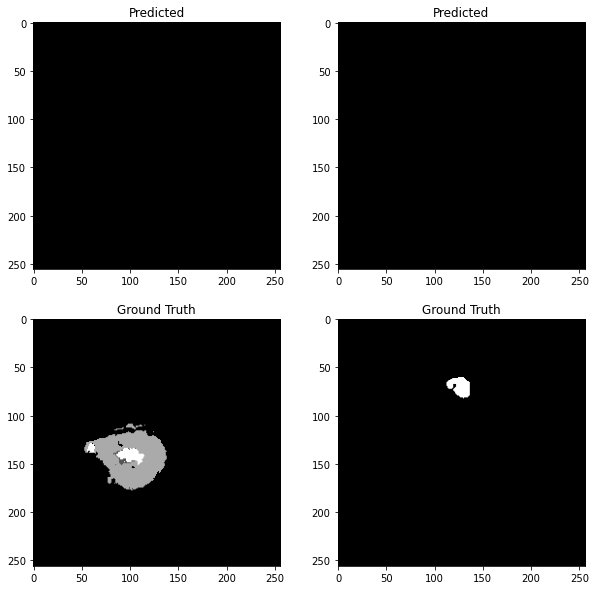

100%|██████████| 2648/2648 [33:29<00:00,  1.32it/s]



Average Training Loss: 0.05487694336576922

Average Training DSC: [0.9882861  0.5608091  0.40222641 0.32808427]
Average Training ASSD: [  3.61143707 117.5532707  123.50762949 141.13437981]


  0%|          | 0/662 [00:00<?, ?it/s]

Validation Prediction Visualization:


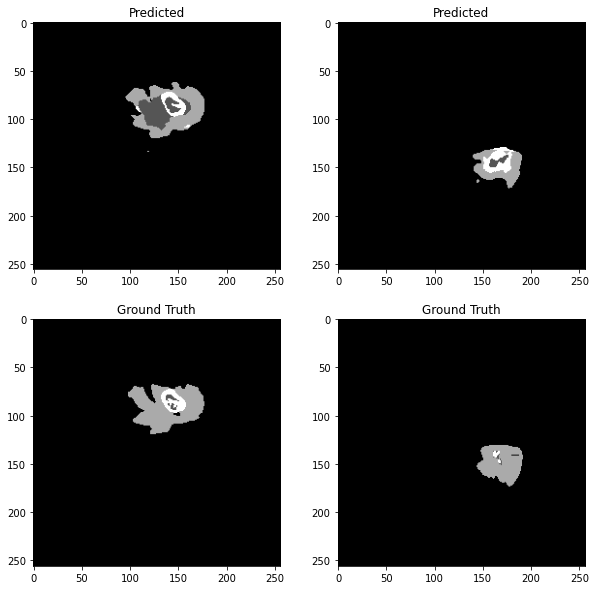

100%|██████████| 662/662 [05:51<00:00,  1.88it/s]


Average Validation Loss: 0.03400421758489036

Average Validation DSC: [0.99671677 0.5979336  0.44169686 0.43122545]
Average Validation ASSD: [  0.65299386  75.10696102 120.51479473  86.19116907]
Epoch 2/50
-------------------------


  0%|          | 0/2648 [00:00<?, ?it/s]

Training Prediction Visualization:


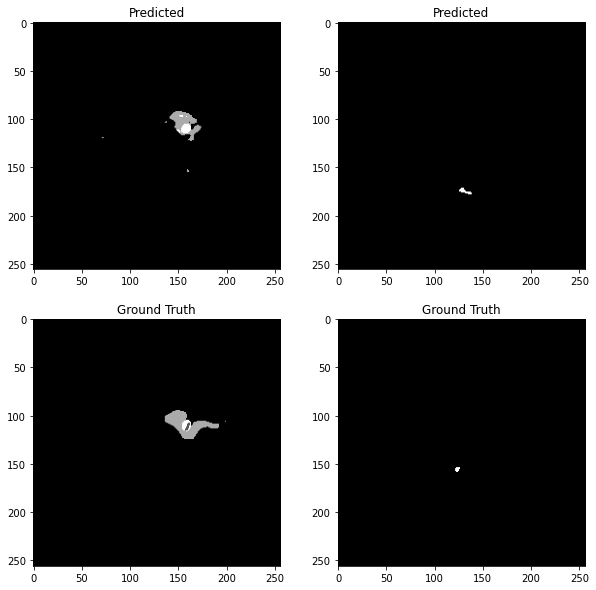

100%|██████████| 2648/2648 [34:45<00:00,  1.27it/s]



Average Training Loss: 0.022805267954428096

Average Training DSC: [0.99763474 0.71593843 0.63495899 0.60456797]
Average Training ASSD: [ 0.50647129 50.08682075 66.62421165 35.92031812]


  0%|          | 0/662 [00:00<?, ?it/s]

Validation Prediction Visualization:


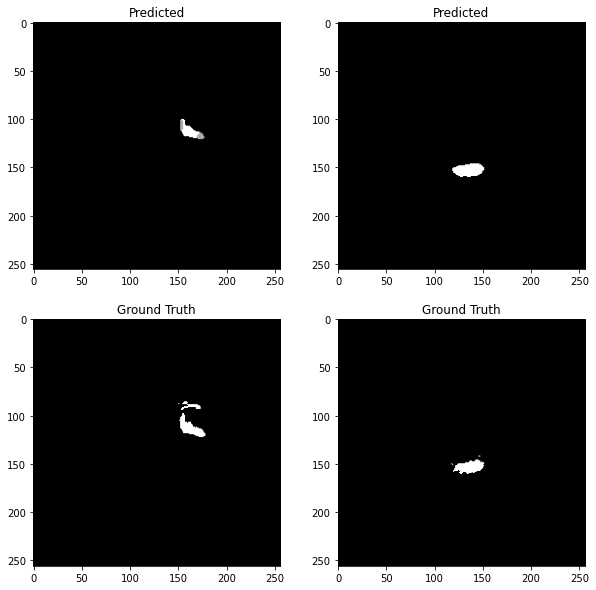

100%|██████████| 662/662 [05:49<00:00,  1.89it/s]


Average Validation Loss: 0.01925665471460839

Average Validation DSC: [0.99784845 0.76439889 0.71923748 0.67250327]
Average Validation ASSD: [ 0.43147902 38.11839776 46.49455632 22.41066353]
Epoch 3/50
-------------------------


  0%|          | 0/2648 [00:00<?, ?it/s]

Training Prediction Visualization:


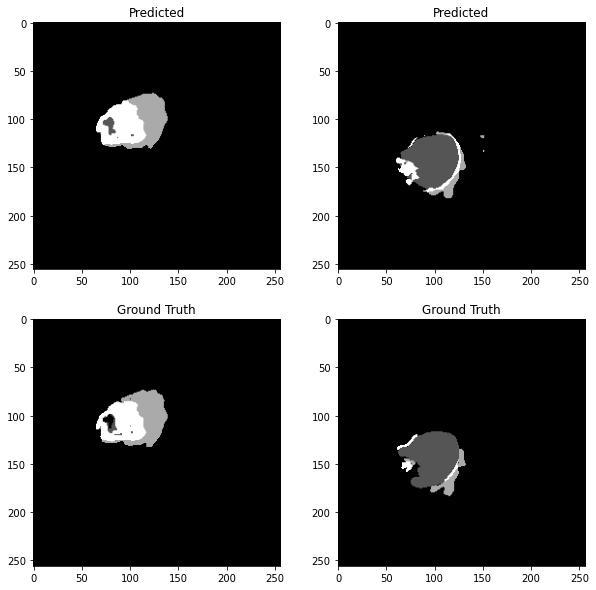

100%|██████████| 2648/2648 [34:52<00:00,  1.27it/s]



Average Training Loss: 0.017363276812170557

Average Training DSC: [0.99798458 0.78036992 0.75716803 0.69179279]
Average Training ASSD: [ 0.40779626 36.53709943 36.47552416 23.49951718]


  0%|          | 0/662 [00:00<?, ?it/s]

Validation Prediction Visualization:


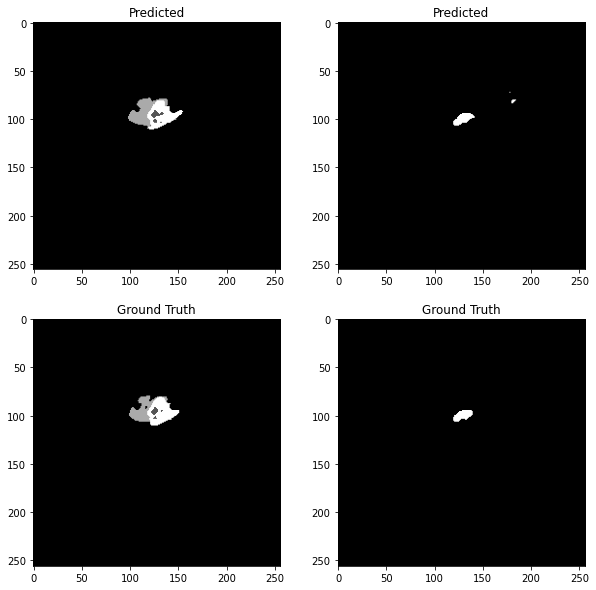

100%|██████████| 662/662 [05:49<00:00,  1.89it/s]


Average Validation Loss: 0.01611995948070598

Average Validation DSC: [0.99810973 0.78992877 0.73726653 0.70829267]
Average Validation ASSD: [ 0.39639731 34.1335115  48.04106949 18.67962369]
Epoch 4/50
-------------------------


  0%|          | 0/2648 [00:00<?, ?it/s]

Training Prediction Visualization:


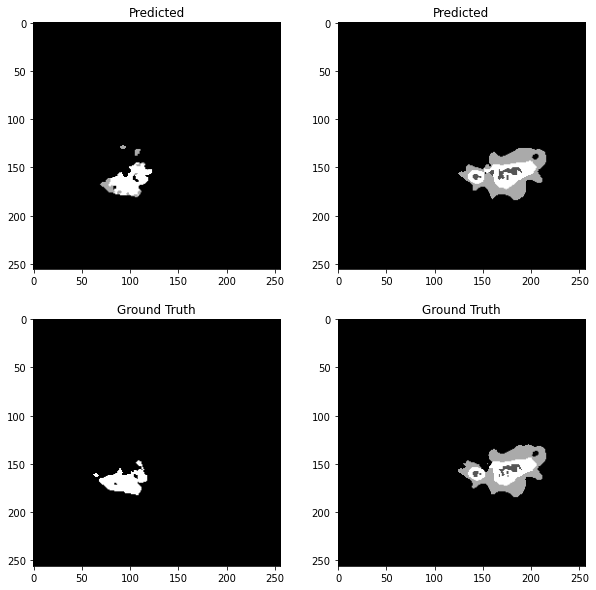

100%|██████████| 2648/2648 [35:12<00:00,  1.25it/s]



Average Training Loss: 0.014571832733515797

Average Training DSC: [0.99825882 0.80378327 0.79481737 0.72071275]
Average Training ASSD: [ 0.33923893 32.02205854 29.35788895 20.76291022]


  0%|          | 0/662 [00:00<?, ?it/s]

Validation Prediction Visualization:


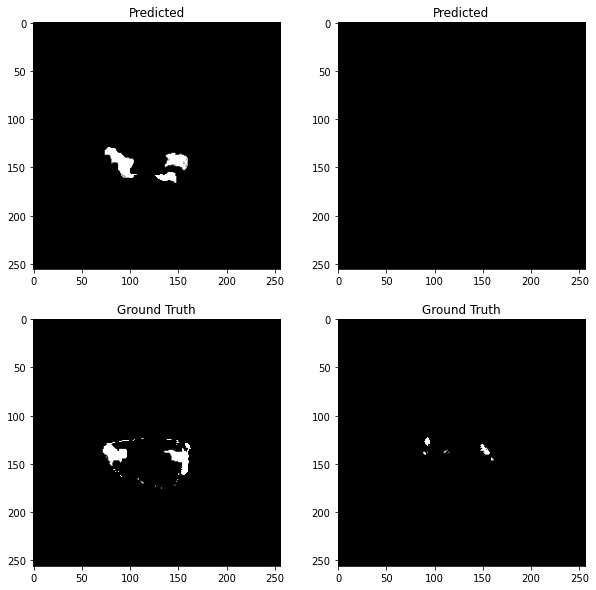

100%|██████████| 662/662 [05:50<00:00,  1.89it/s]


Average Validation Loss: 0.013215068119980418

Average Validation DSC: [0.99841268 0.81571731 0.79403614 0.72154915]
Average Validation ASSD: [ 0.32779016 29.41797145 32.44918185 25.06501491]
Epoch 5/50
-------------------------


  0%|          | 0/2648 [00:00<?, ?it/s]

Training Prediction Visualization:


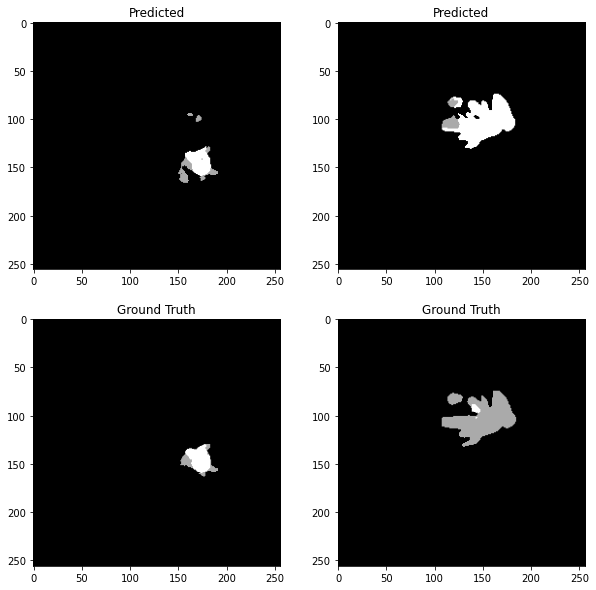

100%|██████████| 2648/2648 [35:01<00:00,  1.26it/s]



Average Training Loss: 0.01238661022326456

Average Training DSC: [0.9984937  0.82309709 0.82148241 0.74226767]
Average Training ASSD: [ 0.28583406 28.11357507 24.64625157 19.74572889]


  0%|          | 0/662 [00:00<?, ?it/s]

Validation Prediction Visualization:


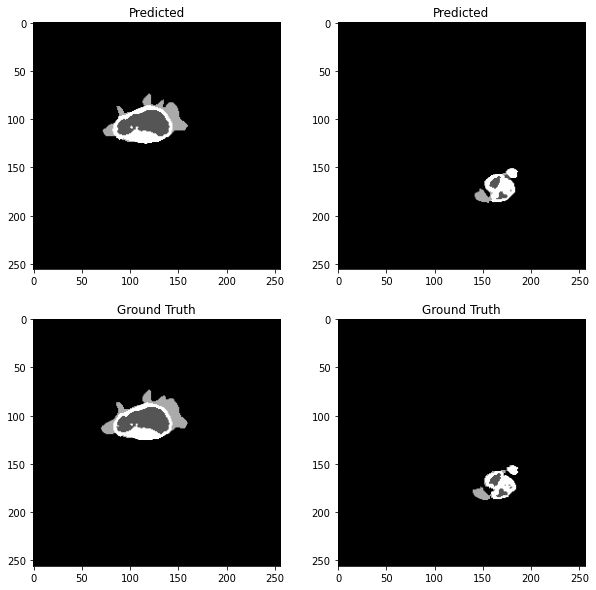

100%|██████████| 662/662 [05:47<00:00,  1.91it/s]


Average Validation Loss: 0.012366500046537497

Average Validation DSC: [0.99848012 0.83201665 0.82388203 0.73512873]
Average Validation ASSD: [ 0.30060115 26.36426707 23.10539532 23.86092544]
Epoch 6/50
-------------------------


  0%|          | 0/2648 [00:00<?, ?it/s]

Training Prediction Visualization:


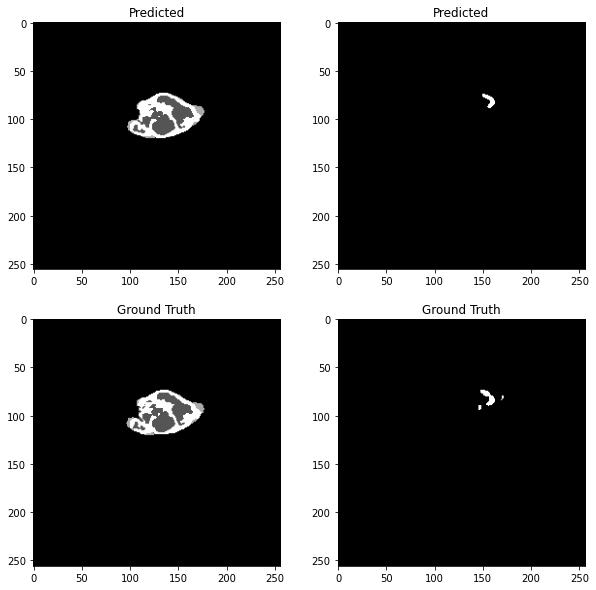

100%|██████████| 2648/2648 [34:53<00:00,  1.26it/s]



Average Training Loss: 0.01065240482735698

Average Training DSC: [0.99867622 0.83739629 0.84333544 0.76181443]
Average Training ASSD: [ 0.24079366 25.56025084 20.65585331 18.30235096]


  0%|          | 0/662 [00:00<?, ?it/s]

Validation Prediction Visualization:


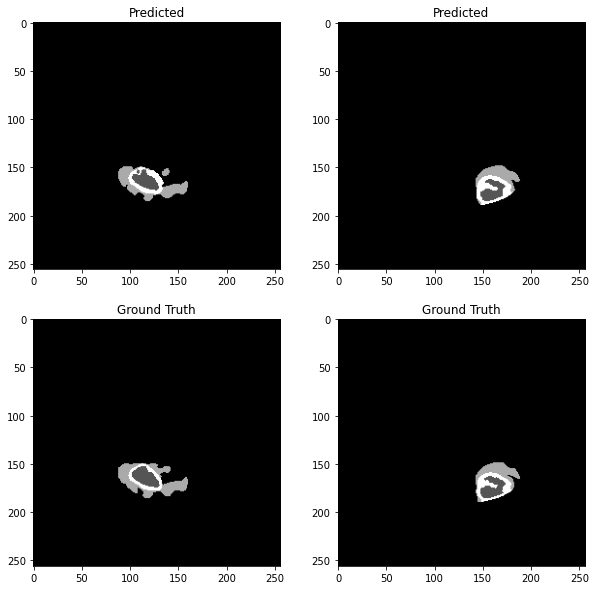

100%|██████████| 662/662 [05:51<00:00,  1.88it/s]


Average Validation Loss: 0.010587846448791306

Average Validation DSC: [0.99875582 0.82725688 0.83856852 0.76317482]
Average Validation ASSD: [ 0.22121836 26.64480346 23.6606692  17.58407988]
Epoch 7/50
-------------------------


  0%|          | 0/2648 [00:00<?, ?it/s]

Training Prediction Visualization:


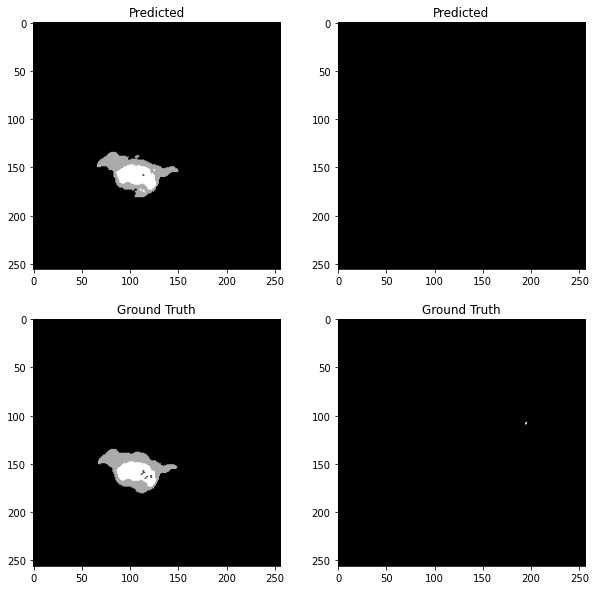

100%|██████████| 2648/2648 [35:17<00:00,  1.25it/s]



Average Training Loss: 0.009470613706565751

Average Training DSC: [0.9988039  0.84800145 0.85984861 0.77787239]
Average Training ASSD: [ 0.20845962 23.82309595 17.54450472 17.34703958]


  0%|          | 0/662 [00:00<?, ?it/s]

Validation Prediction Visualization:


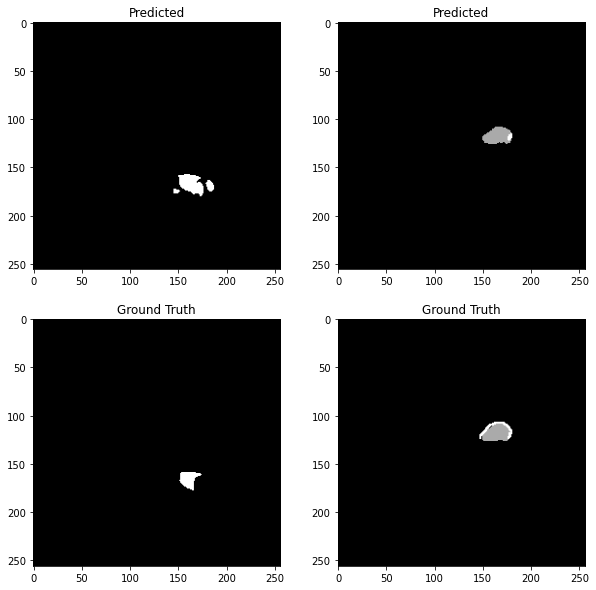

100%|██████████| 662/662 [05:54<00:00,  1.87it/s]


Average Validation Loss: 0.009509110898539154

Average Validation DSC: [0.9988133  0.8487191  0.8473947  0.78206739]
Average Validation ASSD: [ 0.20300798 22.92423192 21.13995759 14.57919072]
Epoch 8/50
-------------------------


  0%|          | 0/2648 [00:00<?, ?it/s]

Training Prediction Visualization:


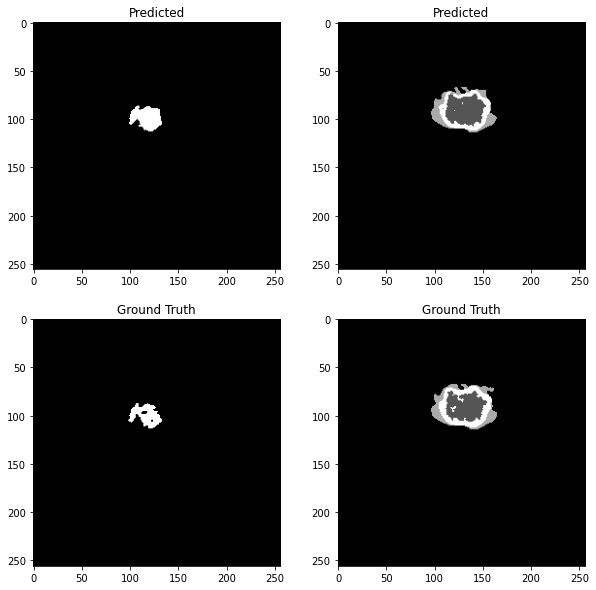

100%|██████████| 2648/2648 [34:44<00:00,  1.27it/s]



Average Training Loss: 0.008505112976553285

Average Training DSC: [0.99890768 0.85752881 0.87398728 0.79376372]
Average Training ASSD: [ 0.18157378 22.32455802 15.01791004 16.07797691]


  0%|          | 0/662 [00:00<?, ?it/s]

Validation Prediction Visualization:


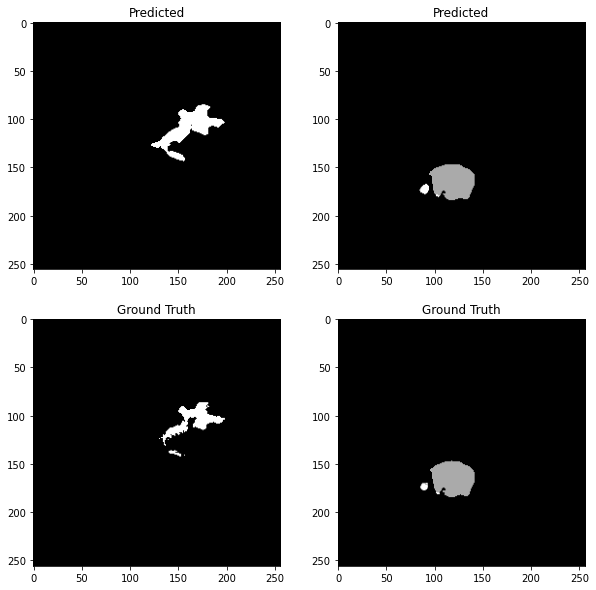

100%|██████████| 662/662 [05:48<00:00,  1.90it/s]


Average Validation Loss: 0.00913075352821983

Average Validation DSC: [0.99888132 0.84806251 0.86955101 0.79316589]
Average Validation ASSD: [ 0.17746483 23.1689187  16.33041307 12.3015004 ]
Epoch 9/50
-------------------------


  0%|          | 0/2648 [00:00<?, ?it/s]

Training Prediction Visualization:


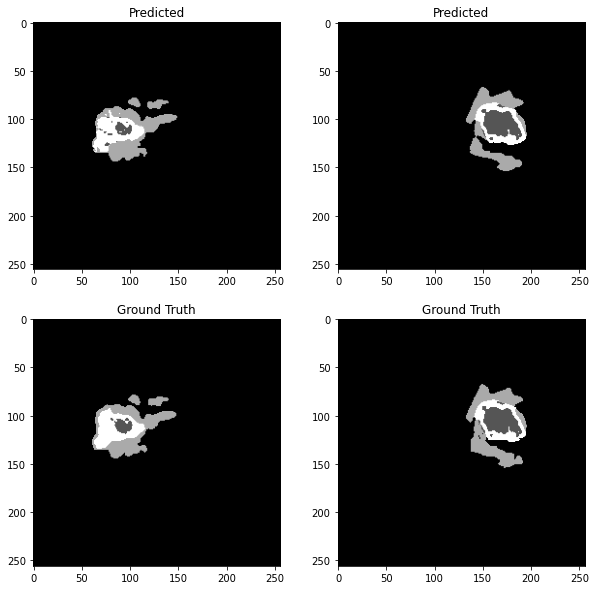

100%|██████████| 2648/2648 [34:29<00:00,  1.28it/s]



Average Training Loss: 0.0077941179260740965

Average Training DSC: [0.99898711 0.86445525 0.88444798 0.80581611]
Average Training ASSD: [ 0.16243041 20.8980076  13.30747431 15.23987944]


  0%|          | 0/662 [00:00<?, ?it/s]

Validation Prediction Visualization:


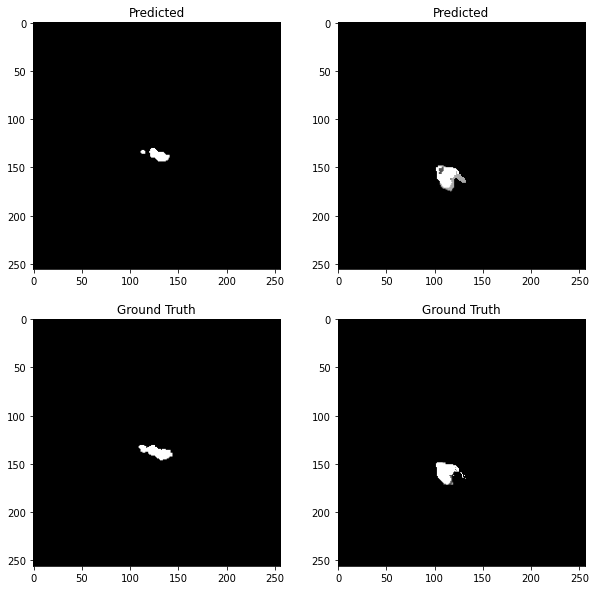

100%|██████████| 662/662 [05:50<00:00,  1.89it/s]


Average Validation Loss: 0.008600290637502723

Average Validation DSC: [0.99893482 0.85706649 0.87924575 0.78621279]
Average Validation ASSD: [ 0.1742997  21.30101933 14.47101797 16.42548538]
Epoch 10/50
-------------------------


  0%|          | 0/2648 [00:00<?, ?it/s]

Training Prediction Visualization:


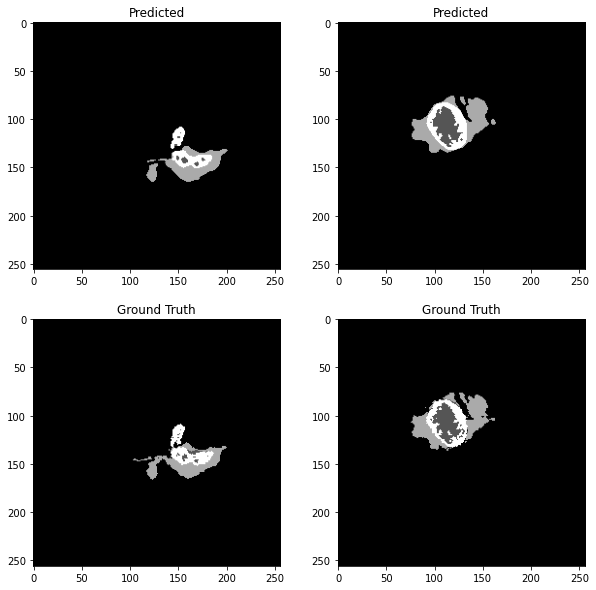

100%|██████████| 2648/2648 [34:48<00:00,  1.27it/s]



Average Training Loss: 0.007281166845665305

Average Training DSC: [0.99904469 0.86991023 0.89312905 0.81592671]
Average Training ASSD: [ 0.14939284 19.98890736 11.63864352 14.44384926]


  0%|          | 0/662 [00:00<?, ?it/s]

Validation Prediction Visualization:


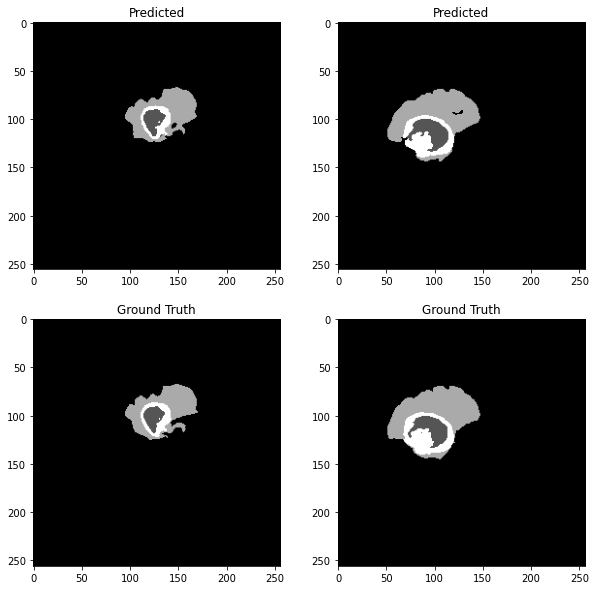

100%|██████████| 662/662 [05:51<00:00,  1.88it/s]


Average Validation Loss: 0.008142679418349959

Average Validation DSC: [0.9990183  0.86783444 0.88338737 0.79622531]
Average Validation ASSD: [ 0.17300168 19.56330258 15.01381215 18.36381098]
Epoch 11/50
-------------------------


  0%|          | 0/2648 [00:00<?, ?it/s]

Training Prediction Visualization:


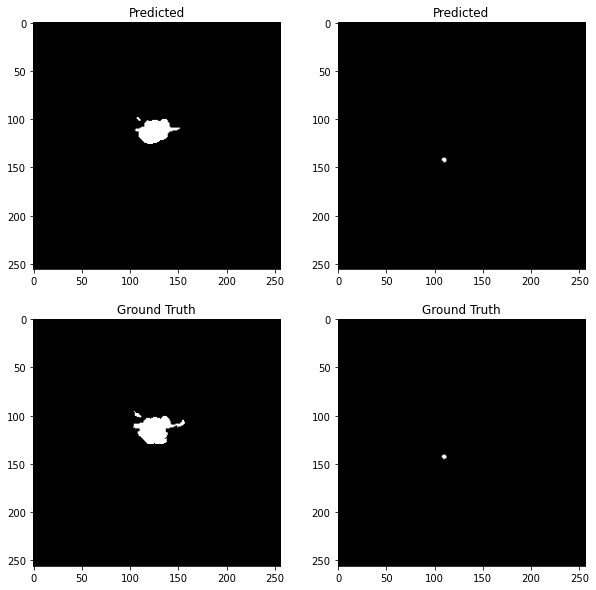

100%|██████████| 2648/2648 [35:03<00:00,  1.26it/s]



Average Training Loss: 0.006730519763135641

Average Training DSC: [0.99910681 0.87660871 0.90042507 0.82511676]
Average Training ASSD: [ 0.13459487 18.54139352 10.50383658 13.86294123]


  0%|          | 0/662 [00:00<?, ?it/s]

Validation Prediction Visualization:


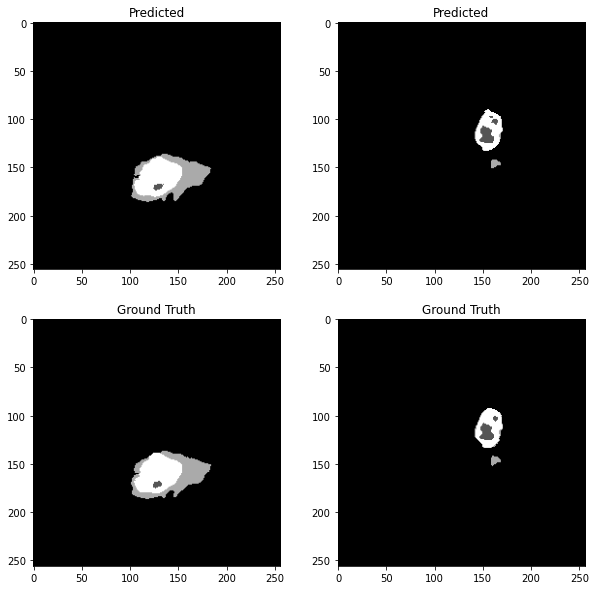

100%|██████████| 662/662 [05:53<00:00,  1.87it/s]


Average Validation Loss: 0.007910801936222346

Average Validation DSC: [0.99904786 0.8700289  0.88045153 0.81565729]
Average Validation ASSD: [ 0.14490273 19.07891485 16.5844913  12.62990629]
Epoch 12/50
-------------------------


  0%|          | 0/2648 [00:00<?, ?it/s]

Training Prediction Visualization:


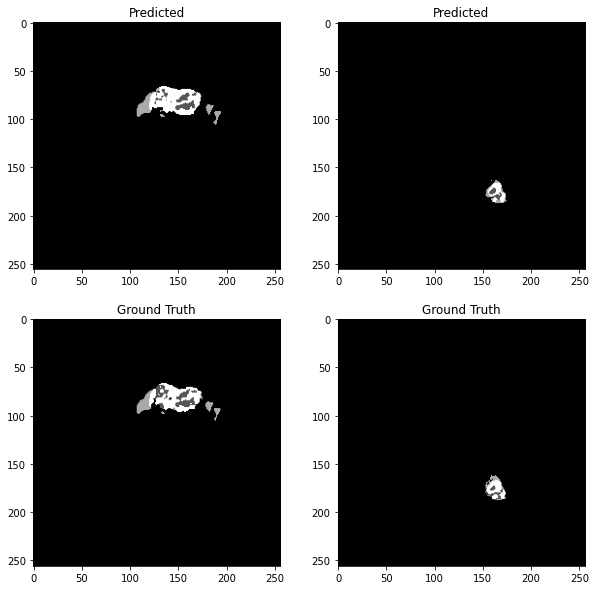

100%|██████████| 2648/2648 [34:58<00:00,  1.26it/s]



Average Training Loss: 0.0063813314484741845

Average Training DSC: [0.99914909 0.88131059 0.9066919  0.83233622]
Average Training ASSD: [ 0.12711247 17.4420896   9.24779539 13.52441671]


  0%|          | 0/662 [00:00<?, ?it/s]

Validation Prediction Visualization:


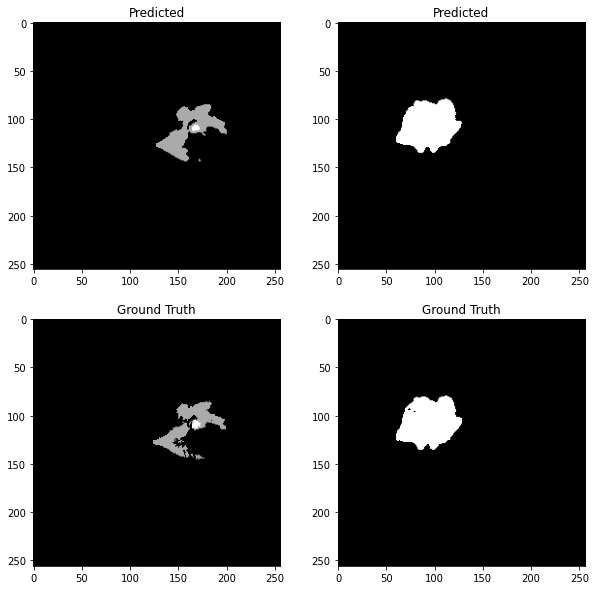

100%|██████████| 662/662 [05:50<00:00,  1.89it/s]


Average Validation Loss: 0.007858094319650549

Average Validation DSC: [0.99904217 0.86907149 0.87165195 0.80650685]
Average Validation ASSD: [ 0.15722698 18.45234487 19.2124745  16.99693808]
Epoch 13/50
-------------------------


  0%|          | 0/2648 [00:00<?, ?it/s]

Training Prediction Visualization:


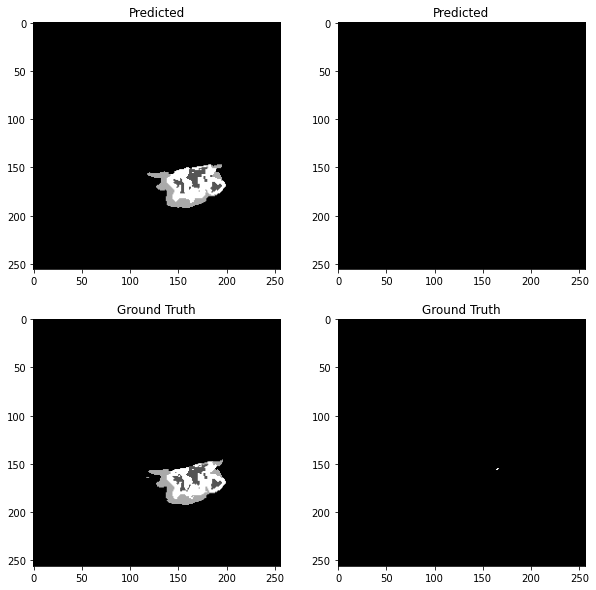

100%|██████████| 2648/2648 [35:01<00:00,  1.26it/s]



Average Training Loss: 0.00605450186192964

Average Training DSC: [0.99918086 0.88548322 0.91120331 0.83858001]
Average Training ASSD: [ 0.12017755 16.74453625  8.70751754 13.08144605]


  0%|          | 0/662 [00:00<?, ?it/s]

Validation Prediction Visualization:


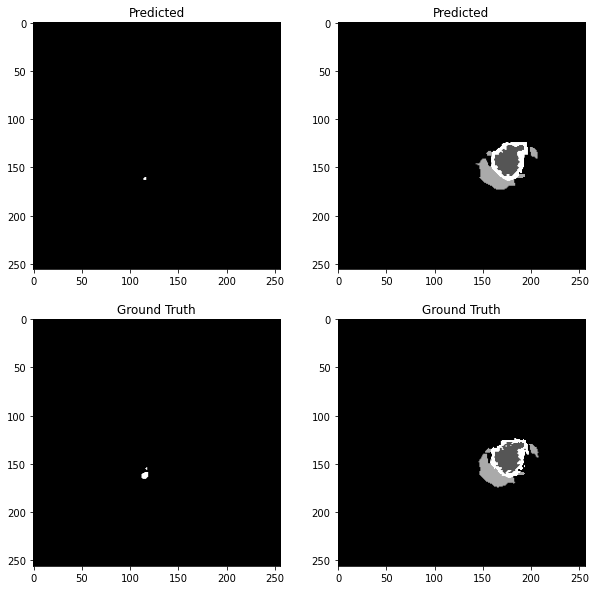

100%|██████████| 662/662 [05:51<00:00,  1.88it/s]


Average Validation Loss: 0.007551831876988498

Average Validation DSC: [0.99913486 0.87878984 0.89400573 0.82673115]
Average Validation ASSD: [ 0.12867804 16.95050939 13.68482651 11.65187138]
Epoch 14/50
-------------------------


  0%|          | 0/2648 [00:00<?, ?it/s]

Training Prediction Visualization:


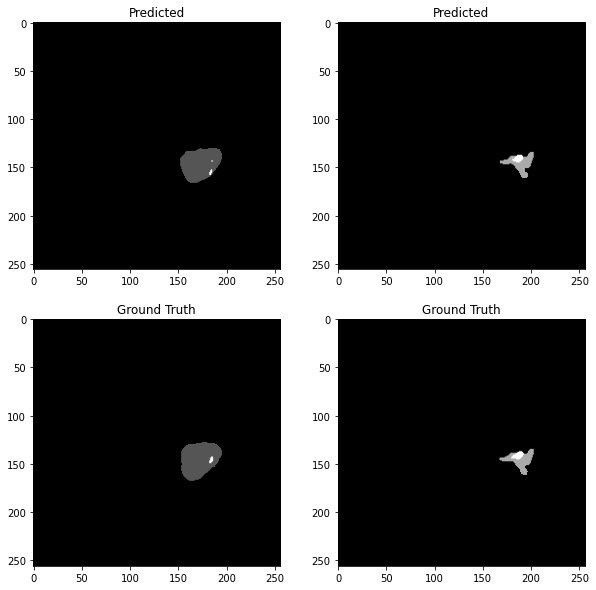

100%|██████████| 2648/2648 [34:25<00:00,  1.28it/s]



Average Training Loss: 0.005823613484470973

Average Training DSC: [0.99921564 0.88987153 0.91520858 0.84349504]
Average Training ASSD: [ 0.11350631 15.62295012  8.13726467 12.8486627 ]


  0%|          | 0/662 [00:00<?, ?it/s]

Validation Prediction Visualization:


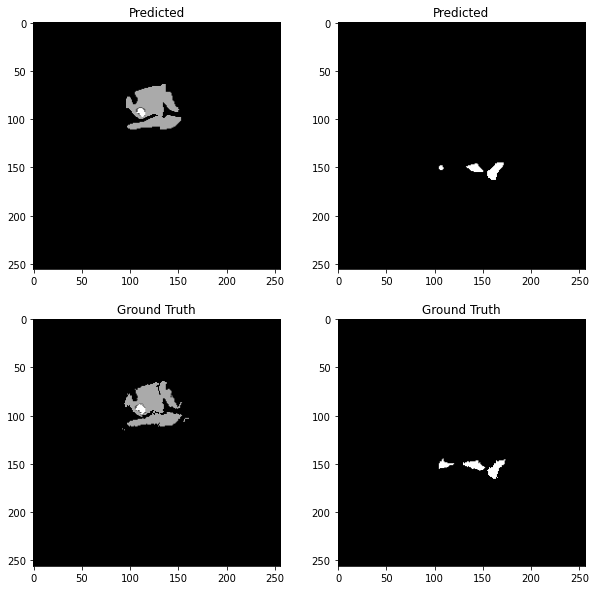

100%|██████████| 662/662 [05:53<00:00,  1.87it/s]


Average Validation Loss: 0.007582079915307305

Average Validation DSC: [0.99909252 0.88068155 0.8876009  0.82219311]
Average Validation ASSD: [ 0.13563957 17.25970919 14.69725285 13.51674114]
Epoch 15/50
-------------------------


  0%|          | 0/2648 [00:00<?, ?it/s]

Training Prediction Visualization:


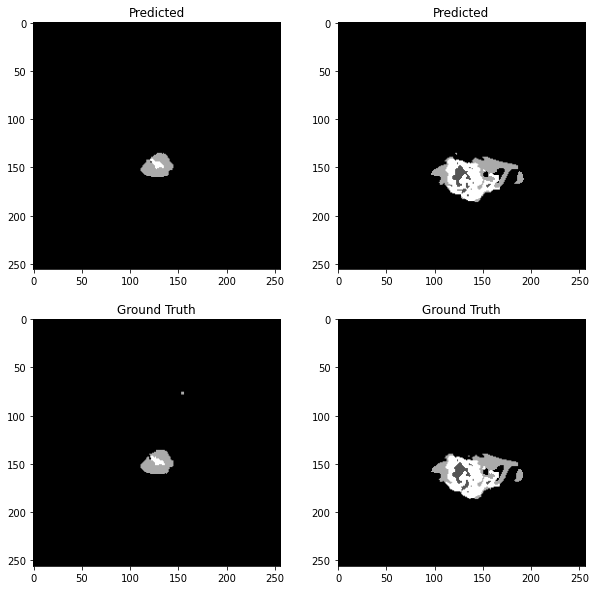

 21%|██▏       | 569/2648 [07:32<27:39,  1.25it/s]

In [ ]:
model = train_model(num_epochs = 50)